
**Kaggle user name: Dhaval Delvadia Public Score: 0.53692 and Private Score 0.54441 **  
Name: Dhaval Delvadia  
Course: CSC 578 Section 710  
Date: 2019-05-24  
Topic: Final Project**


**Objective**:

Given a historical data of climate conditions, we are to predict the temperature of the next hour based on the climate conditions and temperature over the prior 24 hours. To achieve the objective, we employed various neural networks (RNN, LSTM, GRU, Conv1D, etc). 

**Table of contents:**
* Competition and data overview
* Load Python Modules ( data and packages )
* Read data files as dataframes
* Exploration Data Analysis(EDA)
* Network 1: LSTM 1 layer Network (Kaggle score - more than 1; really bad :-( )
* Network 2: Stack (4 layers Network) LSTM + Dropout network (Kaggle score = 0.7775)
* Network 3: Bidirectional Architecture (Kaggle score - 0.612  best score :-) )
* Network 4: Bidirectional network with dropout layers and stacking (Kaggle score - 0.82701)
* Network 5: Bidirectional GRU (Kaggle score - 0.8046)
* Network 6: Conv1D + GRU (Kaggle score - 2.470)
* Network 7: Conv1D + RNN (Kaggle score - 3.114)

**Competition and data overview:**
In this playground competition, we are provided with the challenge of predicting the temperature of the next hour based on the climate conditions and temperature over the prior 24 hours.

In this dataset, 14 different quantities (including air temperature, atmospheric pressure and humidity) were recorded every 10 minutes. The original data goes back to 2003, but we use a subset for this competition, from 2009 to 2016 (both inclusive). Also for our competition, we use a further reduced version in which recordings are kept for every hour.

You explore various neural networks (RNN, LSTM) to solve the problem.  Ones suited for sequences, such as RNN and LSTM, would probably be your starting point.  It's up to you to decide which one or ones to try.

Note that, in addition to network architectures, you can explore 'feature engineering', for example by transforming data or filtering some features, to improve system performance.

There are two data files provided: "climate_hour_train.csv" (the training data) and "climate_hour_Xtest.csv" (the test data).  Those are the same files as the ones on the Competition site.

**Datasets**

The training data file contains climate measurements from "01.01.2009 01:00:00"  (Jan 1, 2009 1:00 am) to "31.12.2014 23:00:00"  (Dec 31, 2014 11:00 pm).  There are 52566 data rows plus one header row at the top, and 15 columns where the first column is "Date time" and the remaining 14 columns are climate measurements (of the date-time).

The test data file contains climate measurements, to predict, from "02.01.2015 00:00:00"  (Jan 2, 2015 0:00 am) to "01.01.2017 00:00:00" (Jan 1, 2017 0:00 am).  But the data is preprocessed already (although by the scheme (**), to be Keras RNN/-ready, only; NOT by (*)), and has 17447 data rows with NO HEADER ROW, and 336 columns where 14 climate measurements over 24 hours are concatenated (i.e., 336 = 14 * 24).  Note that there is no date-time column (nor header row) in this file.

The task of the competition problem is to the training set (but excluding the "Date time" column) to build a model, and apply the model to the test set to generate predictions for the test instances, as you usually do for prediction tasks.  However, there are several important aspects in this problem, which are explained below.

# Load Python Modules

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from pandas.plotting import scatter_matrix
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout  
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Bidirectional
from keras.optimizers import RMSprop
from keras import layers
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['climate_hour_train.csv', 'climate_Xtest.csv', 'sample_submission_2019spring.csv']


# Read data files as dataframes

In [2]:
# load all data
df=pd.read_csv('../input/climate_hour_train.csv')
df.head()

Xtest=pd.read_csv('../input/climate_Xtest.csv', header=None)
Xtest.head(3)

sf=pd.read_csv('../input/sample_submission_2019spring.csv')
sf.head(3)


,date time,temperature
0,02.01.2015 00:00:00,1.580910
1,02.01.2015 01:00:00,1.975897
2,02.01.2015 02:00:00,1.860563


# EDA

### Let's dive into the exploratory data analysis (EDA) of the dataset. Let's first check the data type of the data for the climare_hour_train.csv file.


In [3]:
# let's find out the data type of the climate_hour_train.csv file.  
# based on the output the Date Time is of the object series and not time series. All of the rest of the variables are floating point type.
df.dtypes

Date Time           object
p (mbar)           float64
T (degC)           float64
Tpot (K)           float64
Tdew (degC)        float64
rh (%)             float64
VPmax (mbar)       float64
VPact (mbar)       float64
VPdef (mbar)       float64
sh (g/kg)          float64
H2OC (mmol/mol)    float64
rho (g/m**3)       float64
wv (m/s)           float64
max. wv (m/s)      float64
wd (deg)           float64
dtype: object

#### lets find the missing values in the climate training dataframe; Based on the output, looks like there are no missing values

In [4]:
df.isna().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

#### let's find the summary statistics of each colum for climate training dataframe.  Based on the output, there are 52,566 observations in this dataframe. The mean, standard diviation, and 5 point summary are shown.  The temperature column shows -22.7 deg c min and 35.48 deg C max with mean of 9.17 deg C. This may mean out output should be within these numbers for the prediction of the temperature for test dataset.

In [5]:
# let's find statistics on each variables in the training dataset.
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000
mean,988.723002,9.172795,283.254265,4.779049,76.444300,13.357483,9.458133,3.899249,5.977212,9.568031,1216.718989,2.142170,3.539017,173.689628
std,8.190684,8.533081,8.605048,6.922701,16.430164,7.572008,4.201679,4.723265,2.666892,4.253017,40.439912,1.530832,2.313246,87.251111
min,918.500000,-22.760000,250.850000,-24.800000,13.060000,0.970000,0.810000,0.000000,0.510000,0.810000,1066.190000,0.000000,0.000000,0.000000
25%,983.750000,3.110000,277.242500,0.130000,65.810000,7.640000,6.170000,0.810000,3.890000,6.240000,1188.082500,1.010000,1.800000,120.800000
50%,989.140000,9.310000,283.430000,5.200000,79.700000,11.740000,8.850000,2.090000,5.595000,8.965000,1213.440000,1.790000,3.000000,197.100000
75%,994.070000,15.280000,289.370000,10.030000,89.800000,17.390000,12.320000,5.130000,7.780000,12.450000,1243.050000,2.880000,4.750000,233.800000
max,1012.740000,35.480000,309.690000,22.940000,100.000000,57.800000,28.040000,41.710000,17.940000,28.530000,1392.560000,12.580000,20.330000,360.000000


In [6]:
#convert the first time entry into year, month, day and time
#datetime.strptime(df['Date Time'][0], "%d.%m.%Y %H:%M:%S")

In [7]:
#df.shape[0]

#### Next, let's plot the wd(deg) vs date to see if it's has any patterns

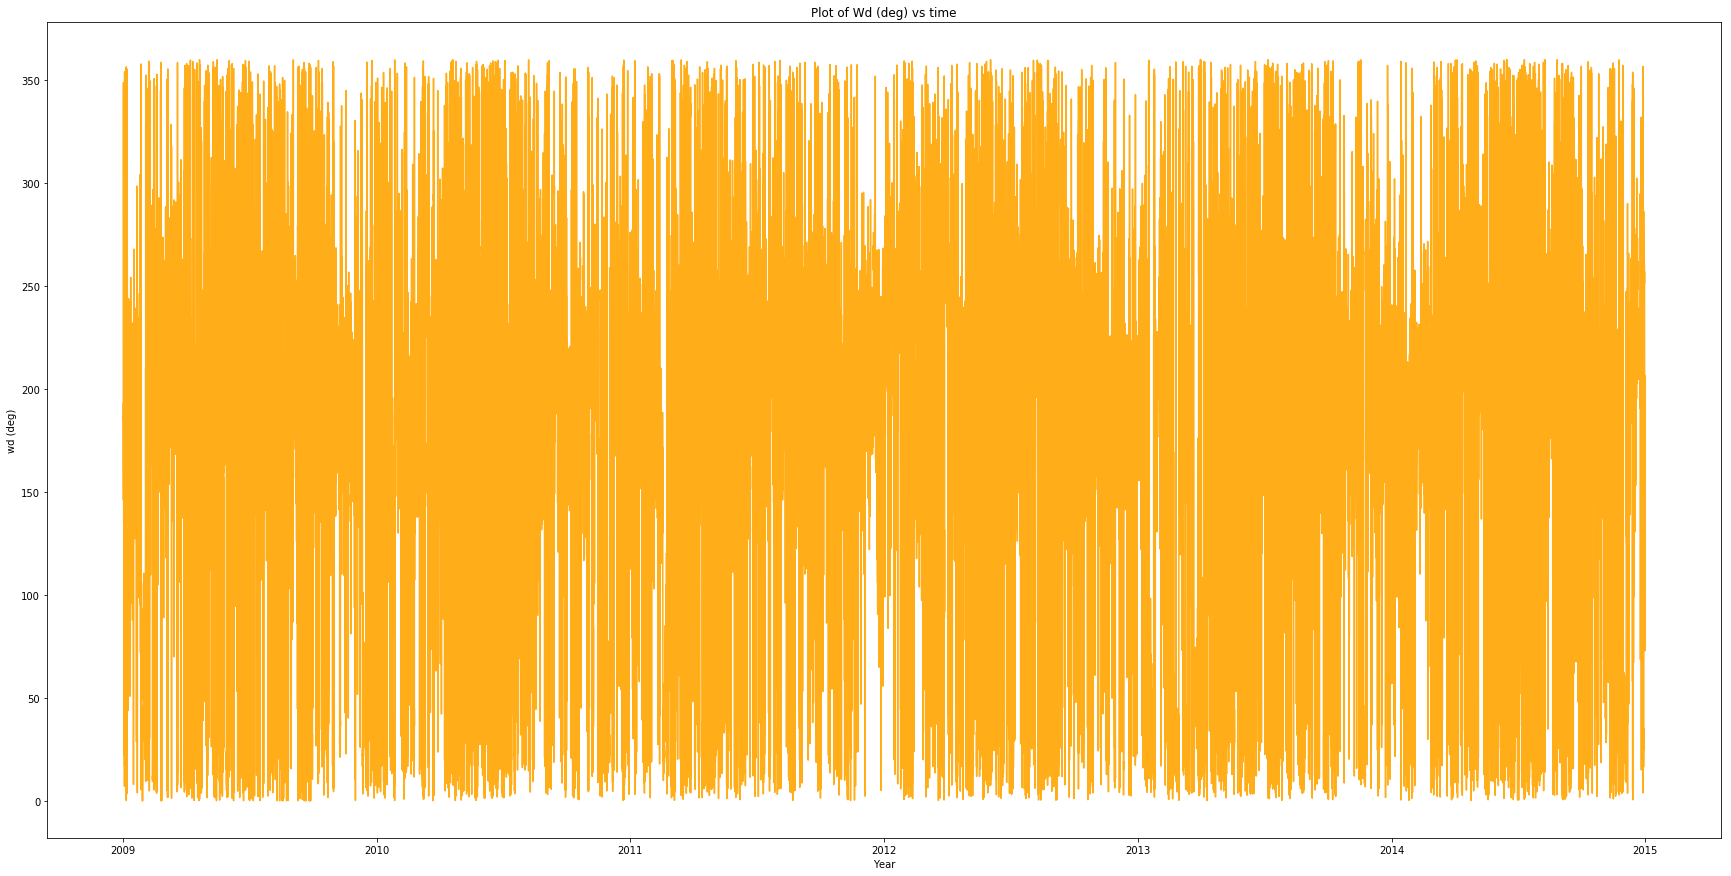

In [8]:
plt.figure(figsize=(30,15))
time = np.array([datetime.strptime(df['Date Time'][i], "%d.%m.%Y %H:%M:%S") for i in range(df.shape[0])])
wd_deg = np.array(df['wd (deg)'])

plt.plot(time, wd_deg, alpha=0.9, color='orange')
plt.xlabel('Year')
plt.ylabel('wd (deg)')
plt.title('Plot of Wd (deg) vs time')
plt.show()

######################### NOT WORKING LOESS SMOOTHING ################
# calculate a smooth curve through the scatter plot
# from statsmodels.nonparametric.smoothers_lowess import lowess
# ys = lowess(time, wd_deg)
# plt.plot(time.values,ys,'red',linewidth=1)
# plt.show()

#### let's plot the date vs temperatuere to see how it looks

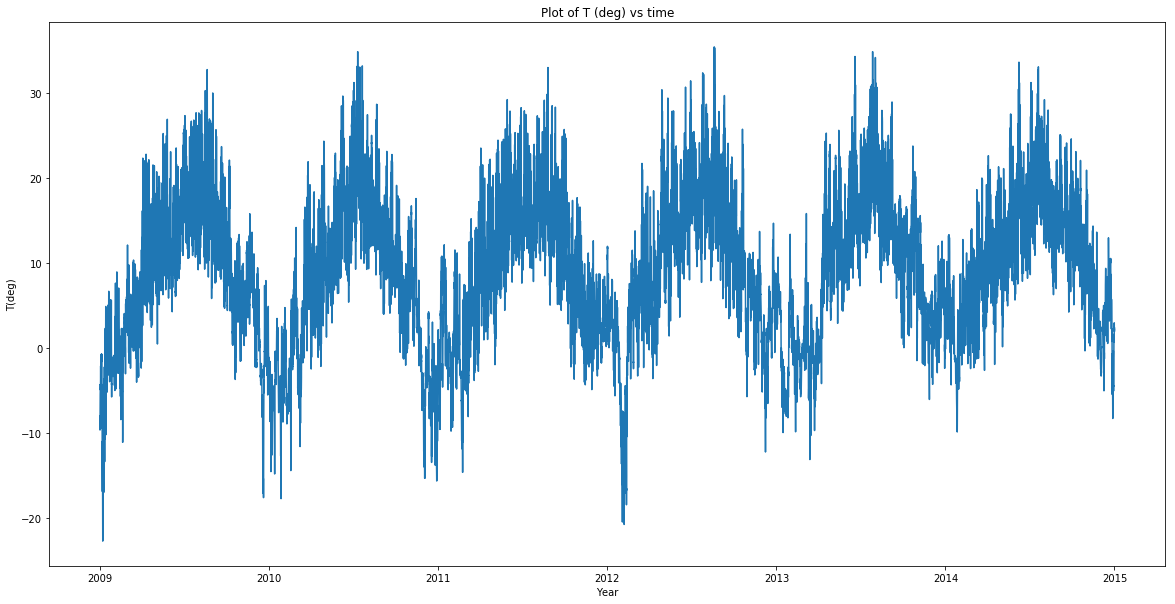

In [9]:
plt.figure(figsize=(20,10))
time = np.array([datetime.strptime(df['Date Time'][i], "%d.%m.%Y %H:%M:%S") for i in range(df.shape[0])])
temp = np.array(df['T (degC)'])

plt.plot(time,temp)
plt.xlabel('Year')
plt.ylabel('T(deg)')
plt.title('Plot of T (deg) vs time')
plt.show()

#### Now let's plot each variable vs time. 

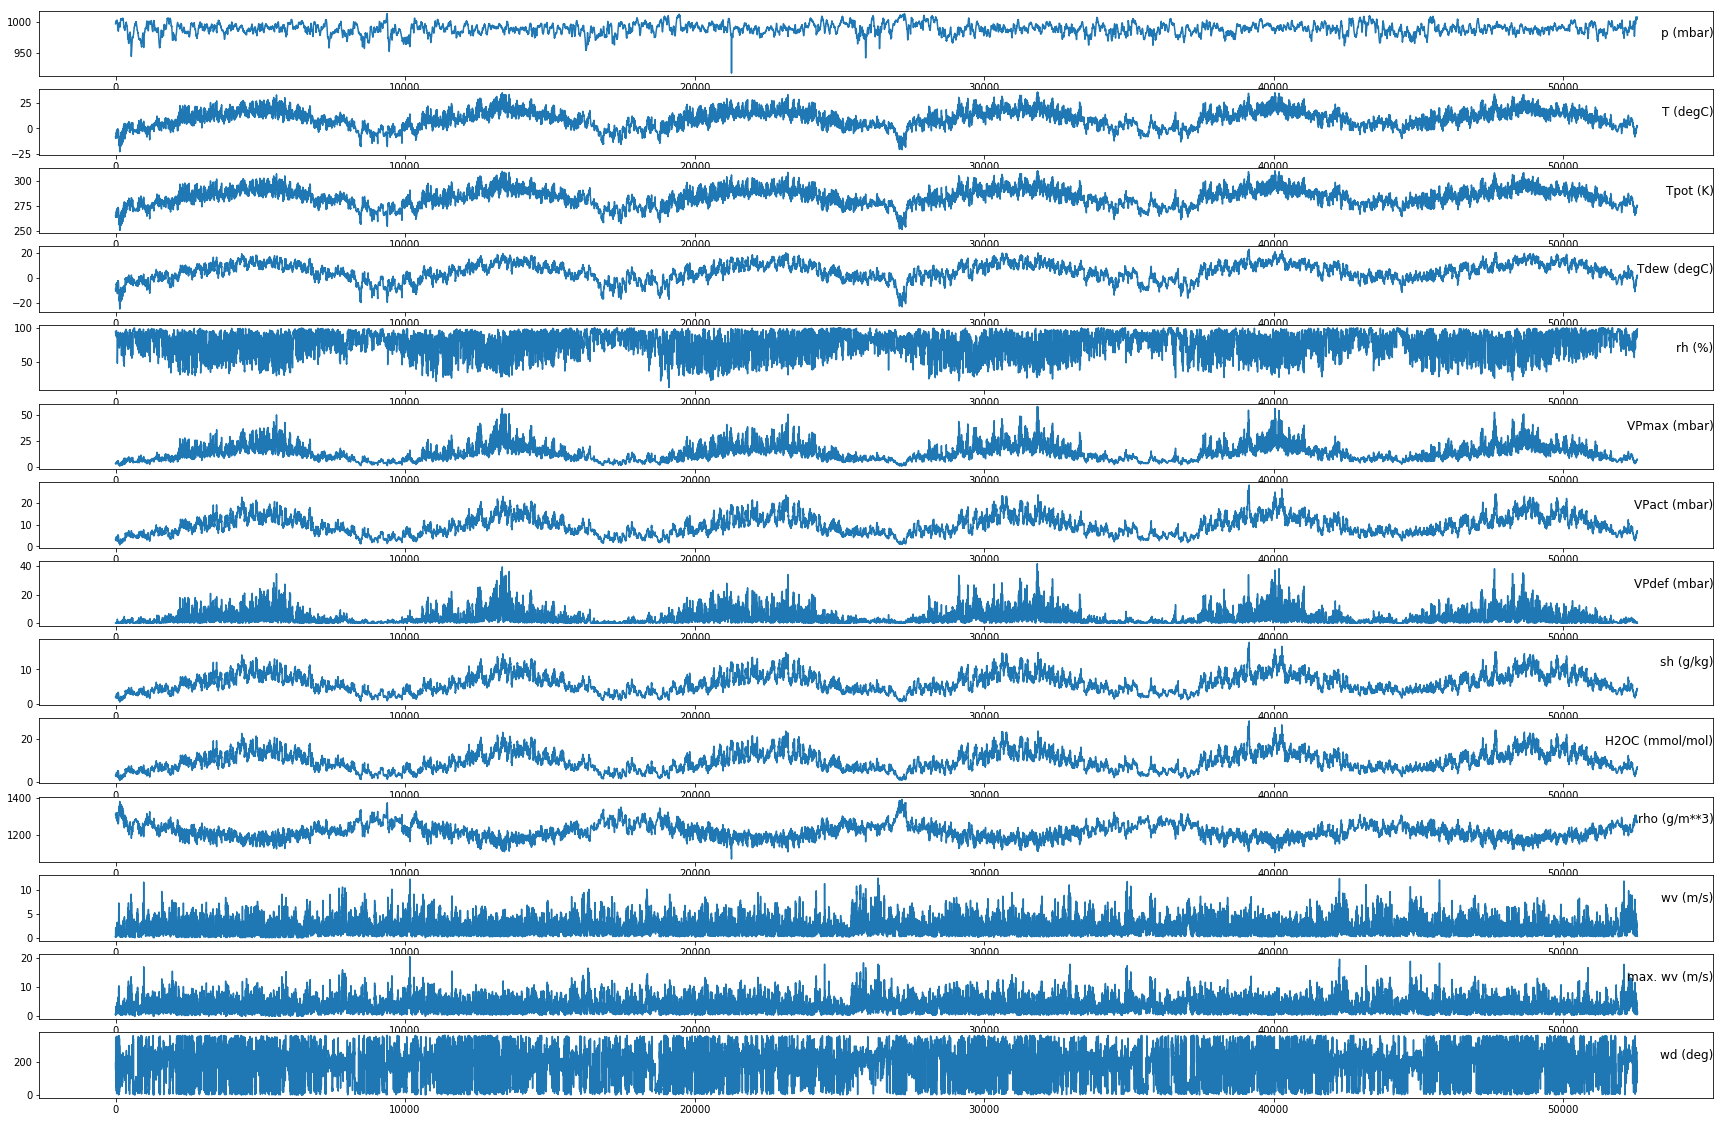

In [10]:
# let's plot all numeric data
values = df.values
# specify columns to plot
groups = list(range(1, 15, 1))
i = 1
# plot each column

plt.figure(figsize=(30,20))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [11]:
# let's plot scatterplot matrix
# scatter_matrix(df, alpha=0.2, figsize=(30, 30), diagonal='kde')

In [12]:
# let's look at the correlation matrix on this dataset
df.corr()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
p (mbar),1.000000,-0.033333,-0.110259,-0.062851,-0.041373,-0.014330,-0.041925,0.014319,-0.056828,-0.056900,0.289338,-0.220537,-0.213808,-0.054692
T (degC),-0.033333,1.000000,0.997023,0.900144,-0.553657,0.950434,0.869535,0.750140,0.868571,0.869025,-0.965265,0.078575,0.114537,0.056148
Tpot (K),-0.110259,0.997023,1.000000,0.899952,-0.547484,0.946404,0.868040,0.745010,0.868244,0.868701,-0.982189,0.095300,0.130527,0.060162
Tdew (degC),-0.062851,0.900144,0.899952,1.000000,-0.143739,0.801853,0.966023,0.426106,0.965342,0.965812,-0.892429,-0.058616,-0.041029,0.067141
rh (%),-0.041373,-0.553657,-0.547484,-0.143739,1.000000,-0.605127,-0.138720,-0.846702,-0.137841,-0.137982,0.492845,-0.306940,-0.356511,-0.022957
VPmax (mbar),-0.014330,0.950434,0.946404,0.801853,-0.605127,1.000000,0.827911,0.866632,0.827431,0.827482,-0.901061,0.084901,0.118126,0.003289
VPact (mbar),-0.041925,0.869535,0.868040,0.966023,-0.138720,0.827911,1.000000,0.437656,0.999859,0.999863,-0.852497,-0.073706,-0.061248,0.032949
VPdef (mbar),0.014319,0.750140,0.745010,0.426106,-0.846702,0.866632,0.437656,1.000000,0.437011,0.437090,-0.686147,0.201684,0.243863,-0.024037
sh (g/kg),-0.056828,0.868571,0.868244,0.965342,-0.137841,0.827431,0.999859,0.437011,1.000000,0.999997,-0.855294,-0.070126,-0.057861,0.033761
H2OC (mmol/mol),-0.056900,0.869025,0.868701,0.965812,-0.137982,0.827482,0.999863,0.437090,0.999997,1.000000,-0.855780,-0.070063,-0.057760,0.034017


#### Based on the correlation matrix, it looks like the target variable Temperature is highly correlated with Tpot(K), Tdew (degC), VPmax(mbar), and rho(g/m**3). We may be able to only use these data to predict the target temeprature. 

#### Also, looks like multicolliniarity between Tdew(degC) and Tpot(K), T(degC) and Tpot(K), VPmax(mbar) and Tpot(K), rho(g/m**3) and Tpot(K), VPact(mbar) and Tdew(degC), Sh(g/kg) and Tdew(degC), H2OC (mmol/mol) and Tdew(degC), rho(g/m**3) and VPmax(mbar), sh(g/kg) and VPact(mbar),  H2OC(mmol/mol) and VPact (mbar), H2OC(mmol/mol) and sh(g/kg), max.vw(m/s) and wv(m/s), 

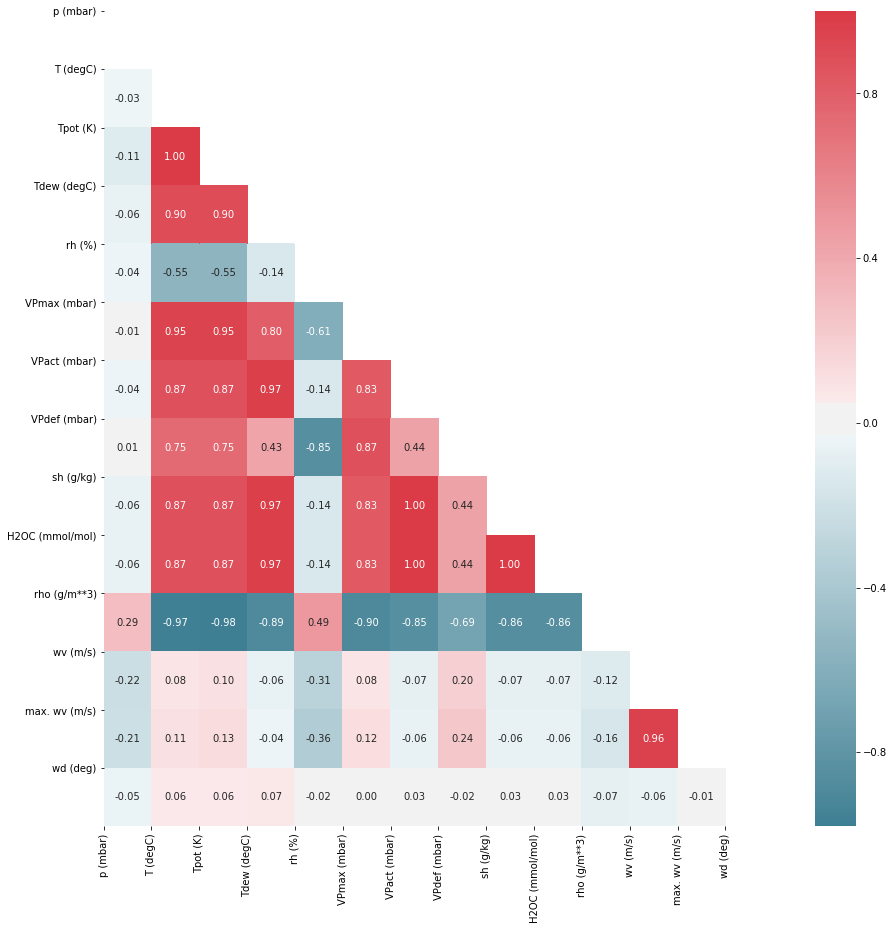

In [13]:
# Create Correlation df
corr = round(df.corr(),2)
#corr.style.background_gradient(cmap='coolwarm') # this line gives corrolation heatmap for top and bottom where as below code only gives bottom

# Plot figsize
fig, ax = plt.subplots(figsize=(15, 15))
# Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
# Drop self-correlations
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
# Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
# Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
# Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
# Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
# show plot
plt.show()

# Z-SCORE DATA TRANSFORMATION AND INVERSE DATA TRANSFORMATION FUNCTIONS

In [14]:
# now let's normalize the dataset using z-score for each column
def zNormalize(dataframe):
    col=list(dataframe.columns)
    dfNorm=pd.DataFrame(columns=col)
    #numCol=dataframe.shape[1]
    for c in col:
        #column=dataframe.iloc[:,c]
        dfNorm[c] = (dataframe[c]-dataframe[c].mean())/dataframe[c].std()
    return dfNorm


# inverse z-score Normalization funcition
def invZNorm(data):
    mean=10.25075
    std=8.01432
    
    zScr=pd.DataFrame(data.ravel())
    invZ=(zScr*std) + mean
    return invZ


# This function converts an array of dataset values into an array of trainX and trainY
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        dataX.append(np.concatenate(a))
        if (i+look_back)<=52565:
            dataY.append(dataset[i+look_back, 1])
    return np.array(dataX), np.array(dataY)

### Drop the Date Time column from the dataframe, df, and assign it to a new dataframe called dataset. Pass the dataset dataframe to zNormalize function to normalize

In [15]:
dataset = df.drop(columns="Date Time")
zNorm=zNormalize(dataset)
zNorm.head(3)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0.949493,-2.018356,-2.077184,-1.958636,1.092850,-1.324283,-1.503716,-0.785315,-1.506327,-1.509054,2.253739,-1.262170,-1.257548,0.217881
1,0.964144,-2.115624,-2.174801,-2.101643,1.019813,-1.352017,-1.560836,-0.781080,-1.562572,-1.565484,2.362295,-1.236041,-1.257548,0.190374
2,0.991004,-2.107421,-2.168990,-2.085754,1.038072,-1.350696,-1.553696,-0.783197,-1.555073,-1.558431,2.360564,-1.281768,-1.257548,-0.074379


In [16]:
# let's plot scatterplot matrix for the zNormalize dataset
# scatter_matrix(zNorm, alpha=0.2, figsize=(30, 30), diagonal='kde')

In [17]:
#let's find correlation data on this z-score normalize dataset
#zNorm.corr()

In [18]:
# Get the values of the zNorm and pass it to create_dataset for splitting into trainX and testY after changing the layout to 24 hours by 14 variables as rows and 52000 as columns 
look_back = 24
trainX, trainY = create_dataset(zNorm.values, look_back)

In [19]:
# let's see the trainX and trainY dataset in data frame format
trainX=pd.DataFrame(trainX)
#trainX.head()

In [20]:
trainY=pd.DataFrame(trainY)
#trainY.head()

In [21]:
# split into train and test sets
valuesX = trainX.values
valuesY = trainY.values

# split into input and outputs
n_train_hours = 42033 # 80% of 52542
train_X = valuesX[:n_train_hours, :]
train_Y = valuesY[:n_train_hours, :]
valid_X = valuesX[n_train_hours :, :]
valid_Y = valuesY[n_train_hours :, :]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 24, 14))
valid_X = valid_X.reshape((valid_X.shape[0], 24, 14))
print(train_X.shape, train_Y.shape, valid_X.shape, valid_Y.shape)

(42033, 24, 14) (42033, 1) (10509, 24, 14) (10509, 1)


### let's do the z-score normalization of test dataset (Xtest) without changing anything (i.e. reshaping etc)

In [22]:
# let's do the z Score normalization of Xtest without changing anything
# let's also try to zNormalize it using the straigh forward passing it to zNormalize function
Xtest_Norm1=zNormalize(Xtest)

# Network 1: LSTM 1 layer Network (Kaggle score - 0.53692 with 100 epochs and batch size = 100)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                13000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 42033 samples, validate on 10509 samples
Epoch 1/100
 - 18s - loss: 0.1707 - val_loss: 0.1043
Epoch 2/100
 - 16s - loss: 0.0851 - val_loss: 0.0728
Epoch 3/100
 - 16s - loss: 0.0722 - val_loss: 0.0658
Epoch 4/100
 - 16s - loss: 0.0659 - val_loss: 0.0666
Epoch 5/100
 - 16s - loss: 0.0630 - val_loss: 0.0647
Epoch 6/100
 - 16s - loss: 0.0637 - val_loss: 0.0623
Epoch 7/100
 - 16s - loss: 0.0601 - val_loss: 

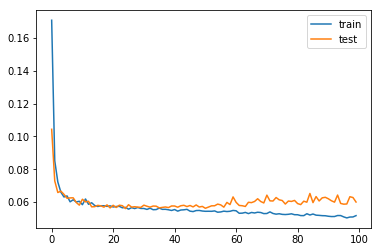

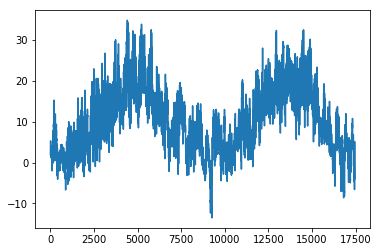

In [23]:
# design LSTM network 1
model = Sequential()
model.add(LSTM(50, input_shape=(24, 14)))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(train_X, train_Y, epochs=100, batch_size=100, validation_data=(valid_X, valid_Y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#model.add(LSTM(n, input_shape=(timesteps, data_dim)))
#where n is the number of neurons you want in an LSTM unit (which is up to you to experiment), and timesteps is 24 and data_dim is 14 in our case.

#predict the output based on zNormalizing all 366 columns
yhat1 = model.predict(np.array(Xtest_Norm1).reshape((Xtest_Norm1.shape[0], 24, 14)))
# now let's rescale yhat1 result doing the inverse zhat1
yPred1=invZNorm(yhat1)
# now let's create panda dataframe of the rescale yhat1 values 
sf["temperature"]=pd.DataFrame(yPred1)
sf.to_csv("submission2.csv", header=True, index=False) # submission2.csv file gave really bad result

# let's plot
plt.plot(yPred1)
plt.show()

# Network 2: Stack (4 layers Network) LSTM + Dropout network (Kaggle score = 0.68517)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 24, 50)            13000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 24, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 24, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 50)            0         
___________________________

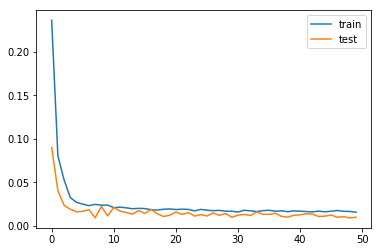

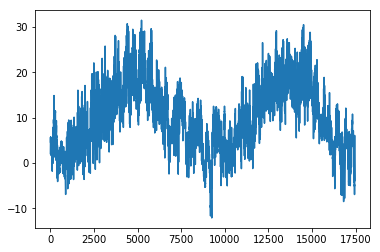

In [24]:
# design LSTM network 2 (This is the network that's performed loss of 0.68517 on Kaggle)
model1 = Sequential()
    
model1.add(LSTM(50, return_sequences=True, input_shape = (24, 14)))
model1.add(Dropout(0.2))
    
model1.add(LSTM(units=50, return_sequences=True))  
model1.add(Dropout(0.2))

model1.add(LSTM(units=50, return_sequences=True))  
model1.add(Dropout(0.2))

model1.add(LSTM(units=50))  
model1.add(Dropout(0.2))
    
model1.add(Dense(1))
model1.compile(loss = "mean_squared_error", optimizer = "adam")
model1.summary()

# fit network
history = model1.fit(train_X, train_Y, epochs=50, batch_size=72, validation_data=(valid_X, valid_Y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


#predict the output based on zNormalizing all 366 columns
yhat3 = model1.predict(np.array(Xtest_Norm1).reshape((Xtest_Norm1.shape[0], 24, 14)))
# now let's rescale yhat1 result doing the inverse zhat1
yPred3=invZNorm(yhat3)
# now let's create panda dataframe of the rescale yhat1 values 
sf["temperature"]=pd.DataFrame(yPred3)
sf.to_csv("submission4.csv", header=True, index=False) # let's call it submission2.csv file

# let's plot
plt.plot(yPred3)
plt.show()

# Network 3: Bidirectional Architecture (Kaggle score - 0.59537) 

Train on 42033 samples, validate on 10509 samples
Epoch 1/25
 - 97s - loss: 0.0754 - val_loss: 0.0303
Epoch 2/25
 - 94s - loss: 0.0250 - val_loss: 0.0167
Epoch 3/25
 - 94s - loss: 0.0118 - val_loss: 0.0148
Epoch 4/25
 - 94s - loss: 0.0101 - val_loss: 0.0095
Epoch 5/25
 - 94s - loss: 0.0090 - val_loss: 0.0083
Epoch 6/25
 - 94s - loss: 0.0084 - val_loss: 0.0077
Epoch 7/25
 - 94s - loss: 0.0084 - val_loss: 0.0075
Epoch 8/25
 - 93s - loss: 0.0085 - val_loss: 0.0078
Epoch 9/25
 - 93s - loss: 0.0085 - val_loss: 0.0085
Epoch 10/25
 - 94s - loss: 0.0083 - val_loss: 0.0085
Epoch 11/25
 - 93s - loss: 0.0080 - val_loss: 0.0085
Epoch 12/25
 - 93s - loss: 0.0079 - val_loss: 0.0086
Epoch 13/25
 - 94s - loss: 0.0078 - val_loss: 0.0086
Epoch 14/25
 - 93s - loss: 0.0078 - val_loss: 0.0086
Epoch 15/25
 - 93s - loss: 0.0077 - val_loss: 0.0085
Epoch 16/25
 - 93s - loss: 0.0076 - val_loss: 0.0084
Epoch 17/25
 - 93s - loss: 0.0075 - val_loss: 0.0082
Epoch 18/25
 - 93s - loss: 0.0075 - val_loss: 0.0083
Epoch

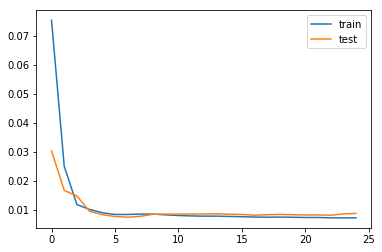

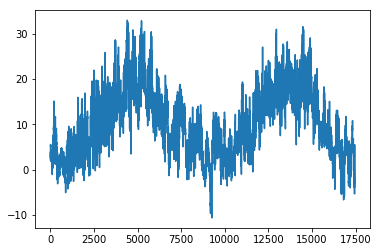

In [25]:
# design Bidirectional network 3 where we will try LSTM 50 layer 1 which will feed the output to the next layer which is also bidirectional which then feeds the output to the single dense layer.
model2 = Sequential()
model2.add(Bidirectional(LSTM(50, return_sequences=True, input_shape=(24,14))))
model2.add(Bidirectional(LSTM(50)))
model2.add(Dense(1))
model2.compile(loss = "mean_squared_error", optimizer = "adam")


# fit network
history = model2.fit(train_X, train_Y, epochs=25, batch_size=64, validation_data=(valid_X, valid_Y), verbose=2, shuffle=False)
model2.summary()
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#predict the output based on zNormalizing all 366 columns
yhat4 = model2.predict(np.array(Xtest_Norm1).reshape((Xtest_Norm1.shape[0], 24, 14)))
# now let's rescale yhat1 result doing the inverse zhat1
yPred4=invZNorm(yhat4)
# now let's create panda dataframe of the rescale yhat1 values 
sf["temperature"]=pd.DataFrame(yPred4)
sf.to_csv("submission5.csv", header=True, index=False) # let's call it submission5.csv file

# let's plot
plt.plot(yPred4)
plt.show()

# Network 4: Bidirectional network with dropout layers and stacking (Kaggle score - 0.86028) 

Train on 42033 samples, validate on 10509 samples
Epoch 1/20
 - 194s - loss: 0.1354 - val_loss: 0.0650
Epoch 2/20
 - 186s - loss: 0.0609 - val_loss: 0.0458
Epoch 3/20
 - 186s - loss: 0.0429 - val_loss: 0.0207
Epoch 4/20
 - 186s - loss: 0.0247 - val_loss: 0.0216
Epoch 5/20
 - 186s - loss: 0.0241 - val_loss: 0.0212
Epoch 6/20
 - 186s - loss: 0.0231 - val_loss: 0.0422
Epoch 7/20
 - 186s - loss: 0.0221 - val_loss: 0.0137
Epoch 8/20
 - 186s - loss: 0.0228 - val_loss: 0.0248
Epoch 9/20
 - 186s - loss: 0.0206 - val_loss: 0.0173
Epoch 10/20
 - 186s - loss: 0.0200 - val_loss: 0.0125
Epoch 11/20
 - 186s - loss: 0.0188 - val_loss: 0.0182
Epoch 12/20
 - 186s - loss: 0.0185 - val_loss: 0.0119
Epoch 13/20
 - 186s - loss: 0.0178 - val_loss: 0.0150
Epoch 14/20
 - 186s - loss: 0.0211 - val_loss: 0.0168
Epoch 15/20
 - 185s - loss: 0.0190 - val_loss: 0.0107
Epoch 16/20
 - 185s - loss: 0.0158 - val_loss: 0.0120
Epoch 17/20
 - 186s - loss: 0.0178 - val_loss: 0.0182
Epoch 18/20
 - 186s - loss: 0.0184 - val_

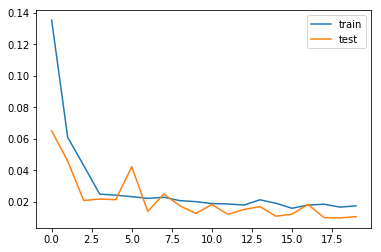

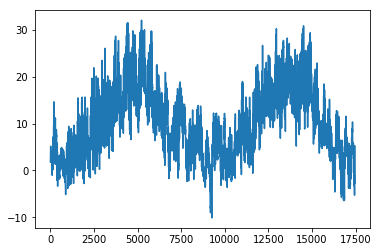

In [26]:
# design Bidirectional network 3 where we will try LSTM 50 layer 1 which will feed the output to the next layer which is also bidirectional which then feeds the output to the single dense layer.
model3 = Sequential()
model3.add(Bidirectional(LSTM(50, return_sequences=True, input_shape=(24,14))))
model3.add(Dropout(0.2))

model3.add(Bidirectional(LSTM(50, return_sequences=True)))
model3.add(Dropout(0.2))

model3.add(Bidirectional(LSTM(50, return_sequences=True)))
model3.add(Dropout(0.2))

model3.add(Bidirectional(LSTM(50)))
model3.add(Dropout(0.2))

model3.add(Dense(1))
model3.compile(loss = "mean_squared_error", optimizer = "adam")

# fit network
history = model3.fit(train_X, train_Y, epochs=20, batch_size=64, validation_data=(valid_X, valid_Y), verbose=2, shuffle=False)
model3.summary()
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#predict the output based on zNormalizing all 366 columns
yhat5 = model3.predict(np.array(Xtest_Norm1).reshape((Xtest_Norm1.shape[0], 24, 14)))
# now let's rescale yhat1 result doing the inverse zhat1
yPred5=invZNorm(yhat5)
# now let's create panda dataframe of the rescale yhat1 values 
sf["temperature"]=pd.DataFrame(yPred5)
sf.to_csv("submission6.csv", header=True, index=False) # let's call it submission6.csv file

# let's plot
plt.plot(yPred5)
plt.show()

# Network 5: Bidirectional GRU (Kaggle score - 0.83155) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 64)                9024      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________
Train on 42033 samples, validate on 10509 samples
Epoch 1/20
 - 29s - loss: 0.0469 - val_loss: 0.0119
Epoch 2/20
 - 25s - loss: 0.0145 - val_loss: 0.0086
Epoch 3/20
 - 25s - loss: 0.0118 - val_loss: 0.0075
Epoch 4/20
 - 25s - loss: 0.0107 - val_loss: 0.0072
Epoch 5/20
 - 25s - loss: 0.0100 - val_loss: 0.0071
Epoch 6/20
 - 25s - loss: 0.0096 - val_loss: 0.0070
Epoch 7/20
 - 25s - loss: 0.0093 - val_loss: 0.0070
Epoch 8/20
 - 25s - loss: 0.0091 - val_loss: 0.0069
Epoch 9/20
 - 25s - loss: 0.0090 - val_loss: 0.0069
Epoch 10/20
 - 25s

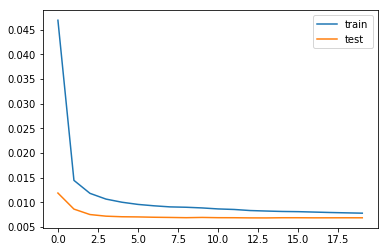

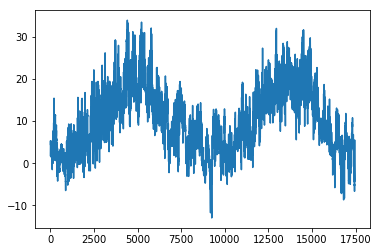

In [27]:
model4 = Sequential()
model4.add(layers.Bidirectional(layers.GRU(32), input_shape=(24,14)))
model4.add(layers.Dense(1))
model4.compile(optimizer=RMSprop(), loss="mean_squared_error")
model4.summary()

# fit network
history = model4.fit(train_X, train_Y, epochs=20, batch_size=100, validation_data=(valid_X, valid_Y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#predict the output based on zNormalizing all 366 columns
yhat6 = model4.predict(np.array(Xtest_Norm1).reshape((Xtest_Norm1.shape[0], 24, 14)))
# now let's rescale yhat result doing the inverse zhat1
yPred6=invZNorm(yhat6)
# now let's create panda dataframe of the rescale yhat1 values 
sf["temperature"]=pd.DataFrame(yPred6)
sf.to_csv("submission7.csv", header=True, index=False) # let's call it submission6.csv file

# let's plot
plt.plot(yPred6)
plt.show()

# Network 6: Conv1D + GRU (Kaggle score - 2.32182) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 20, 32)            2272      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 32)             5152      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Train on 42033 samples, validate on 10509 samples
Epoch 1/30
 - 10s - loss: 0.2764 - val_loss: 0.2049
Epoch 2/30
 - 5s - loss: 0.2191 - va

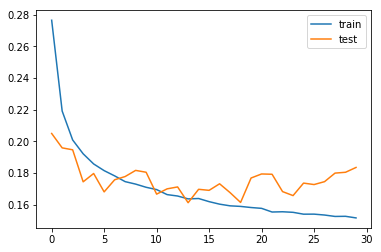

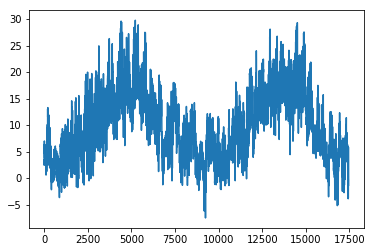

In [28]:
model5=Sequential()
model5.add(layers.Conv1D(32,5, activation='relu', input_shape=(24,14)))
model5.add(layers.MaxPooling1D(3))
model5.add(layers.Conv1D(32,5,activation='relu'))
model5.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.5))
model5.add(layers.Dense(1))
model5.summary()
model5.compile(optimizer=RMSprop(), loss='mae')


# fit network
history = model5.fit(train_X, train_Y, epochs=30, batch_size=64, validation_data=(valid_X, valid_Y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#predict the output based on zNormalizing all 366 columns
yhat7 = model5.predict(np.array(Xtest_Norm1).reshape((Xtest_Norm1.shape[0], 24, 14)))
# now let's rescale yhat result doing the inverse zhat1
yPred7=invZNorm(yhat7)
# now let's create panda dataframe of the rescale yhat1 values 
sf["temperature"]=pd.DataFrame(yPred7)
sf.to_csv("submission8.csv", header=True, index=False) # let's call it submission6.csv file

# let's plot
plt.plot(yPred7)
plt.show()

# Network 7: Conv1D + RNN (Kaggle score - 2.70749) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 20, 32)            2272      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6, 32)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2, 32)             5152      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 7,457
Trainable params: 7,457
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 42033 samples, validate on 10509 samples
Epoch 1/30
 

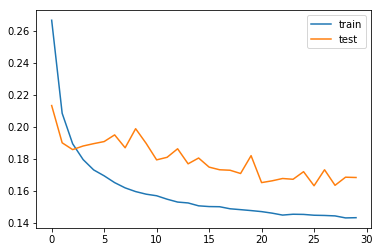

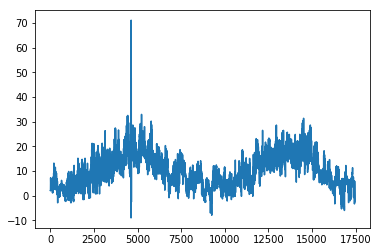

In [29]:
model6=Sequential()
model6.add(layers.Conv1D(32,5, activation='relu', input_shape=(24,14)))
model6.add(layers.MaxPooling1D(3))
model6.add(layers.Conv1D(32,5,activation='relu'))
model6.add(layers.GlobalMaxPooling1D())
model6.add(layers.Dense(1))
model6.compile(optimizer=RMSprop(), loss='mae')
model6.summary()

# fit network
history = model6.fit(train_X, train_Y, epochs=30, batch_size=64, validation_data=(valid_X, valid_Y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#predict the output based on zNormalizing all 366 columns
yhat8 = model6.predict(np.array(Xtest_Norm1).reshape((Xtest_Norm1.shape[0], 24, 14)))
# now let's rescale yhat result doing the inverse zhat1
yPred8=invZNorm(yhat8)
# now let's create panda dataframe of the rescale yhat1 values 
sf["temperature"]=pd.DataFrame(yPred8)
sf.to_csv("submission9.csv", header=True, index=False) # let's call it submission6.csv file

# let's plot
plt.plot(yPred8)
plt.show()